In [ ]:
import numpy as np
import scipy.signal
import torch
import random
import math
from tifffile import tifffile
import matplotlib.pyplot as plt

def my3dnorm(x, p=2):
    if p == 2:
        return torch.sqrt(torch.sum(x.pow(2)))
    else:
        return torch.sqrt(torch.sum(x.pow(p)))

def gaussian_3D(X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z,dev='cpu'):
    '''Gaussian 3D centered in 0'''

    X_domain = X_domain.to(dev)
    Y_domain = Y_domain.to(dev)
    Z_domain = Z_domain.to(dev)

    expo = torch.exp(- ( torch.pow(X_domain, 2) /(2*sig_x**2) + torch.pow(Y_domain, 2) /(2*sig_y**2) + torch.pow(Z_domain, 2) /(2*sig_z**2) ) )
    return expo.to(dev)

class Measure3D:
    def __init__(self, amplitude=None, position=None, dev='cpu'):
        if amplitude is None or position is None:
            amplitude = torch.Tensor().to(dev)
            position = torch.Tensor().to(dev)
        assert(len(amplitude) == len(position)
               or len(amplitude) == len(position))
        if isinstance(amplitude, torch.Tensor) and isinstance(position,
                                                              torch.Tensor):
            self.a = amplitude.to(dev)
            self.x = position.to(dev)
        elif isinstance(amplitude, np.ndarray) and isinstance(position,
                                                              np.ndarray):
            self.a = torch.from_numpy(amplitude).to(dev)
            self.x = torch.from_numpy(position).to(dev)
        elif isinstance(amplitude, list) and isinstance(position, list):
            self.a = torch.tensor(amplitude).to(dev)
            self.x = torch.tensor(position).to(dev)
        else:
            raise TypeError("Please check the format of your input")
        self.N = len(amplitude)

    def __add__(self, m):
        a_new = torch.cat((self.a, m.a))
        x_new = torch.cat((self.x, m.x))
        return Measure3D(a_new, x_new, dev)

    def __eq__(self, m):
        if m == 0 and (self.a == torch.Tensor() and self.x == torch.Tensor()):
            return True
        elif isinstance(m, self.__class__):
            return torch.equal(self.a, m.a) and torch.equal(self.x, m.x)
        else:
            return False
    def to(self, dev):
        """
        Sends the Measure3D object to the `device` component (the processor or
        the Nvidia graphics card)
        Parameters
        ----------
        dev : str
            Either `cpu`, `cuda` (default GPU) or `cuda:0`, `cuda:1`, etc.
        Returns
        -------
        None.
        """
        return Measure3D(self.a, self.x, dev=dev)

    def kernel(self, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev='cpu'):
        N = self.N
        x = self.x
        a = self.a

        X_domain = X_domain.to(dev)
        Y_domain = Y_domain.to(dev)
        Z_domain = Z_domain.to(dev)

        acquis = torch.zeros(X_domain.shape, device=dev)

        for i in range(N):
            D = gaussian_3D(X_domain - x[i,0], Y_domain - x[i,1], Z_domain - x[i,2], sig_x, sig_y, sig_z,dev)
            acquis += a[i] * D

        return acquis.clone()

    def acquisition(self, X_domain, Y_domain, Z_domain, N_xy, N_z, sig_x, sig_y, sig_z, nv, dev='cpu'):
        N = self.N
        x = self.x
        a = self.a

        X_domain = X_domain.to(dev)
        Y_domain = Y_domain.to(dev)
        Z_domain = Z_domain.to(dev)

        acquis = torch.zeros(X_domain.shape, device=dev)

        for i in range(N):
            D = gaussian_3D(X_domain - x[i,0], Y_domain - x[i,1], Z_domain - x[i,2], sig_x, sig_y, sig_z,dev)
            acquis += a[i] * D

        # w = nv * torch.randn(N_xy, N_xy, N_z, device=dev, dtype=torch.float32)
        w = 0
        return acquis + w

    def tv(self):
        '''Total variation of the measure: \ell_1 norm of the amplitudes vector'''
        try:
            return torch.linalg.norm(self.a, ord=1)
        except ValueError:
            return 0
    def prune(self, tol=1e-5, dev='cpu'):
        '''Remove the spikes with 0 amplitudes'''
        nnz_a = self.a.clone().detach()
        nnz = torch.abs(self.a) > tol
        nnz_a = nnz_a[nnz]
        nnz_x = self.x.clone().detach()
        nnz_x = nnz_x[nnz]
        m = Measure3D(nnz_a, nnz_x, dev=dev)
        return m

def phi(m, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev='cpu'):
    return m.kernel(X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev)

def phi_vector(a, x, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev='cpu'):
    m_tmp = Measure3D(a, x, dev)
    return m_tmp.kernel(X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev)

def phiAdjoint(acquis, X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, dev='cpu'):
    '''Adjoint operator'''
    if dev=='cuda':
        h_vec = gaussian_3D(X_big, Y_big, Z_big, sig_x, sig_y, sig_z)
        h_vec = h_vec.cuda()
        h_ker = h_vec.reshape(1, 1, X_big.shape[0], X_big.shape[1], X_big.shape[2])
        y_arr = acquis.reshape(1, 1, X_domain.shape[0], X_domain.shape[1], X_domain.shape[2])
        eta = torch.nn.functional.conv3d(h_ker, y_arr, stride=1)
        eta = torch.flip(torch.squeeze(eta), [1, 0])
    else:
        out = gaussian_3D(X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z)
        eta = scipy.signal.convolve(out, acquis, mode='same')
    return eta

def rand_gt(sizeGrid_xy, sizeGrid_z, pixel_size_xy, pixel_size_z, N_mol, margin=0,dev='cpu'):
    '''margin is given in the same measure unit as sizegrid'''
    m = Measure3D(torch.empty(0,0), torch.empty(0,0),dev=dev)

    i = -sizeGrid_xy/2 + margin + torch.rand(N_mol, 1) * (sizeGrid_xy-2*margin)
    j = -sizeGrid_xy/2 + margin + torch.rand(N_mol, 1) * (sizeGrid_xy-2*margin)
    k = -sizeGrid_z/2 + margin + torch.rand(N_mol, 1) * (sizeGrid_z-2*margin)
    a = 0.5 + torch.rand(N_mol)
    x = torch.cat((i, j, k), dim=1)
    m = Measure3D(a,x,dev=dev)
    return m




def etak_L2(measure, y, bg, X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, par_reg, dev='cpu'):
    eta = 1/par_reg * phiAdjoint(y - phi(measure, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev=dev) - bg,
                                 X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, dev=dev)
    return eta
def L2TV_cost_funct(m, y, bg, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, par_reg, dev='cpu'):
    aus = m.kernel(X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev=dev) + bg
    fidelity = 0.5 * my3dnorm(y - aus)
    penalty = par_reg * m.tv()
    return(fidelity + penalty)

def etak_KL(measure, y, bg, X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, par_reg, dev='cpu'):
    ones = torch.ones(y.shape, device=dev)
    aus = phi(measure, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev=dev).to(dev)
    eta = ones - torch.div(y, aus + bg)
    eta = -1/par_reg * phiAdjoint(eta, X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, dev=dev)
    return eta

def KLTV_cost_funct(m, y, bg, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, par_reg, dev='cpu'):
    aus = m.kernel(X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z, dev=dev)
    fidelity = torch.sum(aus + bg - y + y * torch.log(y) - y * torch.log(aus + bg))
    penalty = par_reg * m.tv()
    return(fidelity + penalty)



In [ ]:
def FW_KULLBACK_3D(y, bg, sig_x, sig_y, sig_z, X, Y, Z, X_big, Y_big, Z_big, N_xy, N_z, pixel_size_xy, pixel_size_z,
                            par_reg=1e-5, nIter=5, m_0=Measure3D(torch.Tensor(), torch.Tensor()), verbose=False, plots=False, gt=Measure3D(torch.Tensor(), torch.Tensor()), dev='cpu'):
    def frank_wolfe_step(m, x_new, max_eta):
        a_k = m.a
        x_k = m.x
        Nk = m.N
        if Nk == 0:
            x_k = x_new.reshape(1, -1)
            # Set up your parameter variables as tensors that require gradients
            a_param = (torch.ones(Nk + 1, dtype=torch.float)).to(dev).requires_grad_(True)
        else:
            x_k = torch.cat((x_k, x_new.view(1, -1)), dim=0)
            # Set up your parameter variables as tensors that require gradients
            uno = torch.tensor([1.], dtype=torch.float).to(dev)
            a_param = torch.cat((a_k, uno))
            a_param.requires_grad = True
        if verbose:
            print('FRANK-WOLFE (NON SLIDING) STEP ')
            print(f'New position x^* = {x_new} max value of certificate {max_eta:.4f}')
            print('Measure_k : ')
            print('* x_k : ', x_k)

        # Define an optimizer
        optimizer = torch.optim.LBFGS([a_param])

        # Define your objective function
        def lasso(a_param):
            aus = phi_vector(a_param, x_k, X, Y, Z, sig_x, sig_y, sig_z, dev)
            fidelity = torch.sum(aus + bg - y + y * torch.log(y) - y * torch.log(aus + bg))
            penalty = par_reg * torch.norm(a_param, 1)
            return torch.sum(fidelity + penalty)

        max_iterations = 1  # You can adjust this

        for i in range(max_iterations):
            def closure():
                if torch.is_grad_enabled():
                    optimizer.zero_grad()
                    loss = lasso(a_param)
                    if loss.requires_grad:
                        loss.backward()
                return loss
            optimizer.step(closure)
            for j in range(Nk + 1):
                a_param.data[j] = torch.max(a_param.data[j], torch.tensor([0.], dtype=torch.float)).to(dev)
        # Get the optimized values
        a_k = a_param.detach().clone()
        del a_param, optimizer

        if verbose:
            print('* a_k : ', a_k)
        m = Measure3D(a_k, x_k, dev)
        m = m.prune(dev=dev)
        if verbose:
            print('Pruning:')
            print('* x_k : ', m.x)
            print('* a_k : ', m.a)
        return m

    N_xy_y = len(y)
    y = y.to(dev)

    X = X.to(dev)
    Y = Y.to(dev)
    Z = Z.to(dev)
    X_big = X_big.to(dev)
    Y_big = Y_big.to(dev)
    Z_big = Z_big.to(dev)

    if np.isscalar(bg):
        bg = torch.ones(torch.Tensor.size(y)) * bg
        bg = bg.to(dev)

    Nk = m_0.N
    a_k = m_0.a
    x_k = m_0.x
    measure_k = Measure3D(a_k, x_k, dev=dev)
    energy_vector = torch.zeros(nIter)

    x_star_old = torch.Tensor().to(dev)
    eta_max_old = []

    for k in range(nIter):
        if verbose:
            print('\n' + f'*** Iteration {k + 1} ***')
        eta_V_k = etak_KL(measure_k, y, bg, X, Y, Z, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, par_reg, dev)
        if dev == 'cuda':
            x_star_index = np.unravel_index(eta_V_k.argmax().cpu(), eta_V_k.shape)
        else:
            x_star_index = np.unravel_index(eta_V_k.argmax(), eta_V_k.shape)
        x_star = torch.tensor([
            (x_star_index[0] - N_xy / 2) * pixel_size_xy,
            (x_star_index[1] - N_xy / 2) * pixel_size_xy,
            (x_star_index[2] - N_z / 2) * pixel_size_z
        ], device=dev)
        eta_max = eta_V_k[x_star_index]
        if eta_max >= 1:
            if torch.equal(x_star_old, x_star.to(x_star_old.dtype)) and eta_max_old == eta_max:
                if verbose:
                    print('Certificate argmax = ' + str(eta_max))
                    print('\n---- Stopping criterion: max and argmax value of the certificate not changed ----')
                    print('---- For loop stopped to avoid an infinite loop ----')
                return measure_k, energy_vector[:k]
            else:
                eta_max_old = eta_max
                x_star_old = x_star
                measure_k = frank_wolfe_step(measure_k, x_star, eta_max)
                energy_vector[k] = KLTV_cost_funct(measure_k, y, bg, X, Y, Z, sig_x, sig_y, sig_z, par_reg, dev)

        elif eta_max < 1:
            if verbose:
                print('Certificate argmax = ' + str(eta_max))
                print(f'* Energy: {energy_vector[k]:.3f}')
                print("\n---- Stopping criterion: based on the certificate ----")
            return measure_k, energy_vector[:k]

    if verbose:
        print("\n---- Stopping criterion: End for ----")
    if verbose:
        print('\n' + f'KL-BLASSO with {k + 1} iterations of Boosted SFW')
        print(f'* Regularization parameter Lambda: {par_reg}')
        print('Reconstruction ')
        print('* positions: ', measure_k.x)
        print('* amplitudes : ', measure_k.a)
        if gt.N != 0:
            print('Ground truth ')
            print('* positions: ', gt.x)
            print('* amplitudes : ', gt.a)
    return measure_k, energy_vector


In [ ]:
def Boosted_Sliding_FW_KULLBACK_3D(y, bg, sig_x, sig_y, sig_z, X, Y, Z, X_big, Y_big, Z_big, N_xy, N_z, pixel_size_xy, pixel_size_z,
                                   par_reg, nIter, m_0=Measure3D(torch.Tensor(), torch.Tensor()), BoostPar=float('inf'), verbose=False, plots=False,
                                   gt=Measure3D(torch.Tensor(), torch.Tensor()), dev='cpu'):

    def frank_wolfe_step(m, x_new, max_eta):
        a_k = m.a
        x_k = m.x
        Nk = m.N
        if Nk == 0:
            x_k = x_new.reshape(1, -1)
            # Set up your parameter variables as tensors that require gradients
            a_param = (torch.ones(Nk + 1, dtype=torch.float)).to(dev).detach().requires_grad_(True)
        else:
            x_k = torch.cat((x_k, x_new.view(1, -1)), dim=0)
            # Set up your parameter variables as tensors that require gradients
            uno = torch.tensor([1.], dtype=torch.float).to(dev).detach()
            a_param = torch.cat((a_k, uno))
            a_param.requires_grad = True
        if verbose:
            print('FRANK-WOLFE (NON SLIDING) STEP ')
            print(f'New position x^* = {x_new} max value of certificate {max_eta:.4f}')
            print('Measure_k : ')
            print('* x_k : ', x_k)
        # Define your objective function
        def lasso(a_param):
            aus = phi_vector(a_param, x_k, X, Y, Z, sig_x, sig_y, sig_z, dev)
            fidelity = torch.sum(aus + bg - y + y * torch.log(y) - y * torch.log(aus + bg))
            penalty = par_reg * torch.norm(a_param, 1)
            return (fidelity + penalty)
        # Define an optimizer
        optimizer = torch.optim.LBFGS([a_param])
        max_iterations = 15  # You can adjust this
        for i in range(max_iterations):
            def closure():
                if torch.is_grad_enabled():
                    optimizer.zero_grad()
                loss = lasso(a_param)
                loss.backward()
                return loss
            optimizer.step(closure)
            # Project parameters into the feasible space defined by bounds
            for j in range(Nk + 1):
                a_param.data[j] = max(a_param.data[j], 0)
        # Get the optimized values
        a_k = a_param.detach().clone()
        del a_param, optimizer
        if verbose:
            print('* a_k : ', a_k)
        m = Measure3D(a_k, x_k, dev)
        return m

    def sliding_step(m):
        if verbose:
            print('SLIDING STEP')
        a_k = m.a
        x_k = m.x
        Nk = m.N
        def objective(params):
            a_p = params[:int(len(params) / 4)]
            x_p = params[int(len(params) / 4):]
            x_p = x_p.reshape((len(a_p), 3))
            aus = phi_vector(a_p, x_p, X, Y, Z, sig_x, sig_y, sig_z, dev)
            fidelity = torch.sum(aus + bg - y + y * torch.log(y) - y * torch.log(aus + bg))
            penalty = par_reg * torch.norm(a_p, 1)
            return (fidelity + penalty)
        init_guess = torch.cat((a_k, x_k.view(-1)))
        params = init_guess.clone().detach().requires_grad_(True)
        optimizer = torch.optim.LBFGS([params])
        max_iterations = 1
        for i in range(max_iterations):
            def closure():
                optimizer.zero_grad()
                loss = objective(params)
                loss.backward()
                # print('params=',params)
                for j in range(Nk):
                    params.data[j] = max(params.data[j], 0)
                # print('dopo proiezione positivi params=',params)
                return loss

            optimizer.step(closure)
            # print('optimizer.step(closure)')
            # print('params=',params)
            # project using bounds
            for j in range(Nk):
                params.data[j] = max(params.data[j], 0)
            # print('projection onto positive a')
            # print('params=',params)

        # Get the optimized values
        a_k = params[:int(len(params) / 4)].detach().clone()
        x_k = params[int(len(params) / 4):].detach().clone().reshape(Nk, 3)
        m = Measure3D(a_k, x_k, dev)
        if verbose:
            print('Measure_k: ')
            print('* x_k : ', x_k)
            print('* a_k : ', a_k)
        return m

    N_xy_y = len(y)
    y = y.to(dev)
    X = X.to(dev)
    Y = Y.to(dev)
    Z = Z.to(dev)
    X_big = X_big.to(dev)
    Y_big = Y_big.to(dev)
    Z_big = Z_big.to(dev)
    if np.isscalar(bg):
        bg = torch.ones(torch.Tensor.size(y)) * bg
        bg = bg.to(dev)
    Nk = m_0.N
    a_k = m_0.a
    x_k = m_0.x
    measure_k = Measure3D(a_k, x_k, dev=dev)

    energy_vector = torch.zeros(nIter)
    x_star_old = torch.Tensor().to(dev)
    eta_max_old = torch.Tensor().to(dev)#[]

    eta_V_k = etak_KL(measure_k, y, bg, X, Y, Z, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, par_reg, dev)
    if dev == 'cuda':
        x_star_index = np.unravel_index(eta_V_k.argmax().cpu(), eta_V_k.shape)
    else:
        x_star_index = np.unravel_index(eta_V_k.argmax(), eta_V_k.shape)
    x_star = torch.tensor([
        (x_star_index[0] - N_xy / 2) * pixel_size_xy,
        (x_star_index[1] - N_xy / 2) * pixel_size_xy,
        (x_star_index[2] - N_z / 2) * pixel_size_z
    ], device=dev)
    eta_max = eta_V_k[x_star_index]
    for k in range(nIter):
        if verbose:
            print('\n' + f'*** Iteration {k + 1} ***')
        if torch.equal(x_star_old, x_star.to(x_star_old.dtype)) and eta_max_old == eta_max:
            if verbose:
                print('Certificate argmax = ' + str(eta_max))
                print('\n---- Stopping criterion: max and argmax value of the certificate not changed ----')
                print('---- For loop stopped to avoid an infinite loop ----')
            return measure_k, energy_vector[:k]

        if k>0 and (eta_max_old < eta_max):
            if verbose:
                print('\n---- Stopping criterion: argmax value of the certificate has increased ----')
                print('---- This should not occurr: return the previous reconstruction ----')
            return measure_k_old, energy_vector[:k]

        if eta_max >= 1:
            measure_k_old = measure_k
            eta_max_old = eta_max
            x_star_old = x_star
            measure_k = frank_wolfe_step(measure_k, x_star, eta_max)
            if k == nIter - 1:
                if measure_k.N > 0:
                    if verbose:
                        print('Certificate argmax = ' + str(eta_max))
                        print('Sliding performed at the last iteration')
                    measure_k = sliding_step(measure_k)
                    energy_vector[k] = KLTV_cost_funct(measure_k, y, bg, X, Y, Z, sig_x, sig_y, sig_z, par_reg, dev)
                if verbose:
                    print("\n---- Stopping criterion: maximum number of iterations ----")
            elif (k + 1) % BoostPar == 0:
                if verbose:
                    print('Certificate argmax = ' + str(eta_max))
                    print(f'Sliding step performed every {BoostPar} iterations')
                measure_k = sliding_step(measure_k)

            measure_k = measure_k.prune(dev=dev)
            if verbose:
                print('Pruning:')
                print('* x_k : ', measure_k.x)
                print('* a_k : ', measure_k.a)

            energy_vector[k] = KLTV_cost_funct(measure_k, y, bg, X, Y, Z, sig_x, sig_y, sig_z, par_reg, dev)
            eta_max_old = eta_max
            x_star_old = x_star
            eta_V_k = etak_KL(measure_k, y, bg, X, Y, Z, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, par_reg, dev)
            if dev == 'cuda':
                x_star_index = np.unravel_index(eta_V_k.argmax().cpu(), eta_V_k.shape)
            else:
                x_star_index = np.unravel_index(eta_V_k.argmax(), eta_V_k.shape)
            x_star = torch.tensor([
                (x_star_index[0] - N_xy / 2) * pixel_size_xy,
                (x_star_index[1] - N_xy / 2) * pixel_size_xy,
                (x_star_index[2] - N_z / 2) * pixel_size_z
            ], device=dev)
            eta_max = eta_V_k[x_star_index]

        elif eta_max < 1:
            measure_k_old = measure_k
            if measure_k.N == 0:
                energy_vector[k] = KLTV_cost_funct(measure_k, y, bg, X, Y, Z, sig_x, sig_y, sig_z, par_reg)
                if verbose:
                    print('Certificate argmax = ' + str(eta_max))
                    print(f'* Energy: {energy_vector[k]:.3f}')
                    print("\n---- Stopping criterion: based on the certificate ----")
                return measure_k, energy_vector[:k]
            if verbose:
                print('Sliding step performed when certificate argmax < 1')
                print('Certificate argmax = ' + str(eta_max))
            measure_k = sliding_step(measure_k)
            if verbose:
                print('Pruning:')
                print('* x_k : ', measure_k.x)
                print('* a_k : ', measure_k.a)
            energy_vector[k] = KLTV_cost_funct(measure_k, y, bg, X, Y, Z, sig_x, sig_y, sig_z, par_reg, dev)
            eta_max_old = eta_max
            x_star_old = x_star
            eta_V_k = etak_KL(measure_k, y, bg, X, Y, Z, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, par_reg, dev)
            if dev == 'cuda':
                x_star_index = np.unravel_index(eta_V_k.argmax().cpu(), eta_V_k.shape)
            else:
                x_star_index = np.unravel_index(eta_V_k.argmax(), eta_V_k.shape)
            x_star = torch.tensor([
                (x_star_index[0] - N_xy / 2) * pixel_size_xy,
                (x_star_index[1] - N_xy / 2) * pixel_size_xy,
                (x_star_index[2] - N_z / 2) * pixel_size_z
            ], device=dev)
            eta_max = eta_V_k[x_star_index]

            if eta_max < 1:
                if verbose:
                    print('Certificate argmax = ' + str(eta_max))
                    print(f'* Energy: {energy_vector[k]:.3f}')
                    print("\n---- Stopping criterion: based on the certificate ----")
                return measure_k, energy_vector[:k]

    if verbose:
        print("\n---- Stopping criterion: End for ----")
    if verbose:
        print('\n' + f'KL-BLASSO with {k + 1} iterations of Boosted SFW')
        print(f'* Regularization parameter Lambda: {par_reg}')
        print('Reconstruction ')
        print('* positions: ', measure_k.x)
        print('* amplitudes : ', measure_k.a)
        if gt.N != 0:
            print('Ground truth ')
            print('* positions: ', gt.x)
            print('* amplitudes : ', gt.a)
    return measure_k, energy_vector


In [ ]:
def Homotopy_Boosted_SFW_KULLBACK_3D(acquis, bg, sigma_target, sig_x, sig_y, sig_z, X_domain, Y_domain, Z_domain,
                                     X_big, Y_big, Z_big, N_xy, N_z, pixel_size_xy, pixel_size_z,
                                      nnIter, nIter, m_0=Measure3D(torch.Tensor(), torch.Tensor()), lambda0=None, c=5, BoostPar=float('inf'),
                                     verbose=False, plots=False, gt=Measure3D(torch.Tensor(), torch.Tensor()),dev='cpu'):

    def fidelity(acquis, bg, m):
        aus = phi_vector(m.a, m.x, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z,dev)
        return torch.sum(aus + bg - acquis + acquis * torch.log(acquis) - acquis * torch.log(aus + bg))

    # initialisation
    if np.isscalar(bg):
       bg=torch.ones(torch.Tensor.size(acquis))*bg
       bg = bg.to(dev)

    N_ech_y = len(acquis)

    X_domain = X_domain.to(dev)
    Y_domain = Y_domain.to(dev)
    Z_domain = Z_domain.to(dev)
    X_big = X_big.to(dev)
    Y_big = Y_big.to(dev)
    Z_big = Z_big.to(dev)

    Nk = m_0.N  # discrete measure size
    a_k = m_0.a
    x_k = m_0.x
    measure_k = Measure3D(a_k, x_k,dev=dev)
    eta_max = torch.max(torch.tensor(etak_KL(measure_k, acquis, bg, X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z, 1, dev)))

    energy_vector = torch.zeros(nnIter+1)
    lambda_sequence = torch.zeros(nnIter)
    sigma_sequence = torch.zeros(nnIter+1)
    eta_max_sequence = torch.zeros(nnIter+1)

    if verbose:
        print('sigma_target = ' + str(sigma_target))

    # assign lambda_0
    if lambda0==None:
      par_reg = eta_max
    else:
      par_reg=lambda0

    sigma_sequence[0] = fidelity(acquis, bg, measure_k)
    energy_vector[0] = KLTV_cost_funct(measure_k, acquis, bg, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z,
                                           par_reg, dev)
    eta_max_sequence[0] = eta_max

    for k in range(nnIter):

        lambda_sequence[k] = par_reg # si riferisce al lambda usato nell'iterazione k

        if verbose:
            print('\n\n*** Homotopy iteration n.' + str(k) + ' ***')
            print('max of certificate=' + str(eta_max.item()))
            print('lambda=' + str(par_reg.item()))

        (measure_k, nrj) = Boosted_Sliding_FW_KULLBACK_3D(acquis, bg, sig_x, sig_y, sig_z, X_domain, Y_domain, Z_domain,
                                                   X_big, Y_big, Z_big, N_xy, N_z,
                                                  pixel_size_xy, pixel_size_z, par_reg, nIter, m_0=measure_k,
                                                  BoostPar=BoostPar,
                                                  verbose=verbose, plots=plots, dev=dev)

        sigma_t = fidelity(acquis, bg, measure_k)
        if verbose:
            print('sigma_t=' + str(sigma_t.item()))

        energy_vector[k+1] = KLTV_cost_funct(measure_k, acquis, bg, X_domain, Y_domain, Z_domain, sig_x, sig_y, sig_z,
                                           par_reg, dev)
        sigma_sequence[k+1] = sigma_t

        if sigma_t > sigma_target:
            eta_max = torch.max(etak_KL(measure_k, acquis, bg, X_domain, Y_domain, Z_domain, X_big, Y_big, Z_big, sig_x, sig_y, sig_z,
                                       par_reg, dev))
            eta_max_sequence[k+1] = eta_max
            par_reg = par_reg * eta_max / (c + 1)
        else:
            print("\n---- Stopping criterion based on the homotopy ----")
            return measure_k, energy_vector[:k+1], lambda_sequence[:k], sigma_sequence[:k+1], eta_max_sequence[:k+1]


        if verbose:
            print(f'* Energy : {energy_vector[k].item():.3f}')

    print("\n---- End homotopy for: stopping criterion based on the max number of iterations ----")
    return measure_k, energy_vector, lambda_sequence, sigma_sequence, eta_max_sequence




In [ ]:
# # GPU acceleration if needed
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
# print("[Test] Using {} device".format(device))

sigma = 89 # PSF spread factor on xy
sigma_z = 2*sigma # PSF spread factor on z

N_xy = 190 #grid x-y plane
N_z = 17 #z slices
pixel_size_xy = 65
pixel_size_z = 250
sizeGrid_xy = N_xy * pixel_size_xy
sizeGrid_z = N_z * pixel_size_z

X,Y,Z = torch.meshgrid(torch.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy),
                   torch.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy),
                   torch.linspace(-sizeGrid_z/2,sizeGrid_z/2, N_z))

X_big,Y_big,Z_big = torch.meshgrid(torch.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, 2*N_xy-1),
                   torch.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, 2*N_xy-1),
                   torch.linspace(-sizeGrid_z/2,sizeGrid_z/2, 2*N_z-1))
X = X.to(device)
Y = Y.to(device)
Z = Z.to(device)
X_big = X_big.to(device)
Y_big = Y_big.to(device)
Z_big = Z_big.to(device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


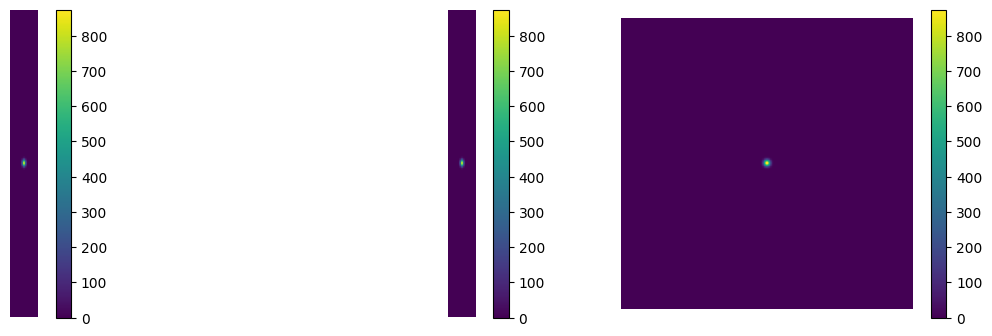

In [ ]:
spike_origin = Measure3D([1000],[[0,0,0]])
spike_origin_blurred = spike_origin.kernel(X,Y,Z, sigma, sigma, sigma_z)
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(torch.amax(spike_origin_blurred[:,:,:],axis=0))
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(torch.amax(spike_origin_blurred[:,:,:],axis=1))
plt.ylabel('y')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(torch.amax(spike_origin_blurred[:,:,:],axis=2))
plt.ylabel('y')
plt.xlabel('x')
plt.colorbar()
plt.axis('off')
plt.show()

Image shape is (190, 190, 17)


<Figure size 1600x400 with 0 Axes>

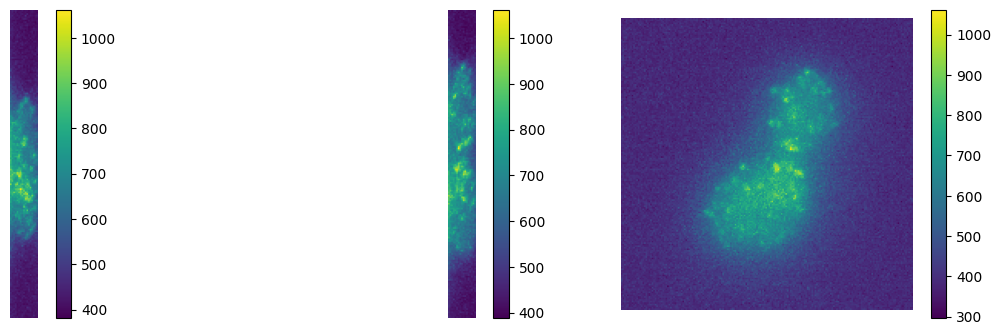

In [ ]:
filename = 'C1-191112_may4_007-1.tif'
img = tifffile.imread(filename)
img = img.transpose()
print(f'Image shape is {img.shape}')
plt.figure(figsize=(16, 4))
# for i in range(3):
#     plt.subplot(1,3,i+1)
#     plt.imshow(np.amax(img[:,:,:],axis=i))
#     plt.colorbar()
# plt.show()
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(np.amax(img[:,:,:],axis=0))
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.amax(img[:,:,:],axis=1))
plt.ylabel('y')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.amax(img[:,:,:],axis=2))
plt.ylabel('y')
plt.xlabel('x')
plt.colorbar()
plt.axis('off')
plt.show()

img = np.array(img, dtype=np.float32)
img_tensor = torch.Tensor(img)

<Figure size 1600x400 with 0 Axes>

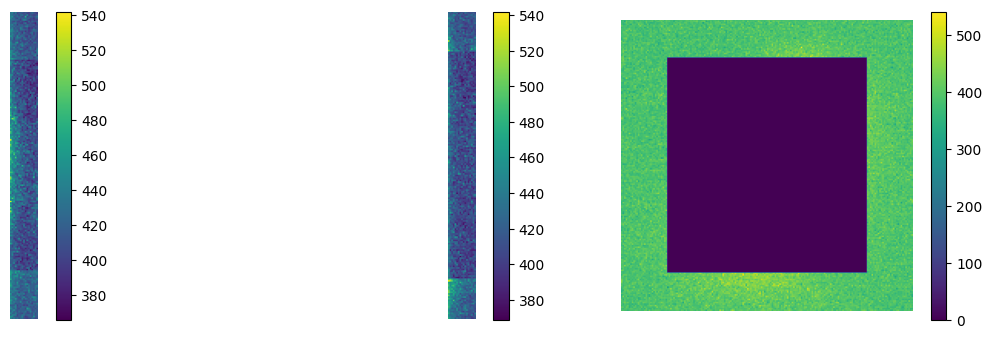

In [ ]:
# Create a new array with the same shape and dtype
outer_part = np.zeros_like(img)

# Copy the outer part into the new array
outer_part[0:25, :, :] = img[0:25, :, :]
outer_part[:, 0:30, :] = img[:, 0:30, :]
outer_part[165:190, :, :] = img[165:190, :, :]
outer_part[:, 160:190, :] = img[:, 160:190, :]
plt.figure(figsize=(16, 4))
# for i in range(3):
#     plt.subplot(1,3,i+1)
#     plt.imshow(np.amax(outer_part[:,:,:],axis=i))
#     plt.colorbar()
# plt.show()
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(np.amax(outer_part[:,:,:],axis=0))
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.amax(outer_part[:,:,:],axis=1))
plt.ylabel('y')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.amax(outer_part[:,:,:],axis=2))
plt.ylabel('y')
plt.xlabel('x')
plt.colorbar()
plt.axis('off')
plt.show()
outer_part_tensor = torch.Tensor(outer_part)

non_zero_elements = outer_part[outer_part != 0]
mean_of_non_zero = np.mean(non_zero_elements)

# background
bg = mean_of_non_zero

In [ ]:
# compute D_kl over the background
m = Measure3D([],[])
aus = m.kernel(X, Y, Z, sigma, sigma, sigma_z)
aus = aus[outer_part != 0]
aus = torch.Tensor(aus)
non_zero_elements = torch.Tensor(non_zero_elements)
sigma_noise_bg = torch.sum(aus+bg-non_zero_elements+non_zero_elements*torch.log(non_zero_elements) - non_zero_elements*torch.log(aus+bg))

sigma_target_bertero = np.shape(img)[0]*np.shape(img)[1]*np.shape(img)[2]/2
sigma_target = sigma_target_bertero*sigma_noise_bg/non_zero_elements.shape[0]*2

In [ ]:
measure_k, energy_vector, lambda_sequence, sigma_sequence, eta_max_sequence = Homotopy_Boosted_SFW_KULLBACK_3D(img_tensor, bg, sigma_target, sigma, sigma, sigma_z, X, Y, Z, X_big, Y_big, Z_big, N_xy, N_z,
                                     pixel_size_xy, pixel_size_z, nnIter=10, nIter=50, m_0=Measure3D(torch.Tensor(), torch.Tensor()),
                                     c=0.5, BoostPar=float('inf'), verbose=True, plots=False, gt=Measure3D(torch.Tensor(), torch.Tensor()),dev='cpu')


Output streaming troncato alle ultime 5000 righe.
        [ 2283.2831, -1025.7158, -1946.4232],
        [-3178.3460,  1964.7351,  -446.2086],
        [  -11.0252,   349.3822, -1453.2576],
        [  630.7857,   756.8358,   442.9991],
        [  994.6835,   602.6934, -1463.0230],
        [-1553.2263,  1163.0483, -1958.5196],
        [ 1854.6237,   986.5269, -1959.1181],
        [ 2832.2777,  -970.3546, -1936.5837],
        [-2530.5280,  1444.4283, -1953.8905],
        [ 1491.0116,    78.8268, -1462.2648],
        [-1742.1630,  1330.1823,  -627.1306],
        [  -99.2449,  1209.8146, -1491.2667],
        [ 1106.9457,  1255.4100, -1875.1713],
        [-1074.3180,  1125.1635, -1446.1764],
        [ 2910.6899,   -21.0391, -1952.9440],
        [ -881.7498,  1579.4613,   236.2253],
        [  236.2206,  -108.3524, -1942.9542],
        [-2991.7609,   831.4511,   817.7917],
        [  385.3734,   587.2868, -1449.7991],
        [ 3326.3816,  -203.0212,  -676.6350],
        [  881.7242,   601.418

In [ ]:
q_xy = 4 # super-resolution factor
q_z = 2
sigma_q_xy = sigma/q_xy
sigma_q_z = sigma_z/q_z

X_plot,Y_plot,Z_plot = torch.meshgrid(torch.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy*q_xy),
                   torch.linspace(-sizeGrid_xy/2,sizeGrid_xy/2, N_xy*q_xy),
                   torch.linspace(-sizeGrid_z/2,sizeGrid_z/2, N_z*q_z))
rec = measure_k.kernel(X_plot,Y_plot,Z_plot, sigma_q_xy, sigma_q_xy, sigma_q_z)

# plt.figure(figsize=(16, 4))
# for i in range(3):
#     plt.subplot(1,3,i+1)
#     plt.imshow(torch.amax(rec[:,:,:],axis=i))
#     plt.colorbar()
# plt.show()
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(torch.amax(rec[:,:,:],axis=0))
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(torch.amax(rec[:,:,:],axis=1))
plt.ylabel('y')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(torch.amax(rec[:,:,:],axis=2))
plt.ylabel('y')
plt.xlabel('x')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
rec_blurred = measure_k.kernel(X,Y,Z, sigma, sigma, sigma_z)+bg
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(torch.amax(rec_blurred[:,:,:],axis=0))
plt.ylabel('x')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(torch.amax(rec_blurred[:,:,:],axis=1))
plt.ylabel('y')
plt.xlabel('z')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(torch.amax(rec_blurred[:,:,:],axis=2))
plt.ylabel('y')
plt.xlabel('x')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
store_rec = rec.numpy().transpose()
%store store_rec
tifffile.imsave('rec.tif', store_rec)

store_rec_blurred = rec_blurred.numpy().transpose()
%store store_rec_blurred
tifffile.imsave('rec_blurred.tif', store_rec_blurred)

# ampl_gt=m_ax0.a
# %store ampl_gt
# pos_gt=m_ax0.x
# %store pos_gt

# ampl_rec=m_sfw.a
# %store ampl_rec
# pos_rec=m_sfw.x
# %store pos_rec

Stored 'store_rec' (ndarray)


<ipython-input-31-32ef766f6677>:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('rec.tif', store_rec)


Stored 'store_rec_blurred' (ndarray)


<ipython-input-31-32ef766f6677>:7: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('rec_blurred.tif', store_rec_blurred)
